# Graph Pipeline Notebook

This notebook demonstrates an end-to-end pipeline for processing satellite data. It performs the following steps:

1. **Import libraries** and set up the environment.
2. **Search for and load** the satellite netCDF files.
3. **Extract data on a GPU** using CuPy and parallel processing.
4. **Clip, bin, and plot** the rasterized chlorophyll‑a data.

Below, the code cells document each step in detail.

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, and plotting.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator  # updated import to follow SOLID principles

### Searching for Data Files

This cell specifies the data directory and recursively searches for netCDF files containing satellite data.

In [3]:
# Specify the data directory and search recursively for netCDF files
data_dir = r"E:\satdata\Mississippi_2021-06-21_2021-07-21"
nc_files = glob.glob(os.path.join(data_dir, '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} files.")

Found 41 files.


### Loading Datasets

Using the custom L2DatasetLoader, this cell loads multiple datasets from the discovered netCDF files.

In [4]:
# Load datasets using a custom L2DatasetLoader
loader = L2DatasetLoader(variable='chlor_a')
datasets = loader.load_multiple(nc_files)
print(f"Loaded {len(datasets)} datasets.")

Loaded 41 datasets.


### GPU Data Extraction

This cell leverages the GPU with CuPy and parallel processing to extract and filter the satellite data.

In [5]:
# Create an instance of GPUDataExtractor and extract data on GPU
extractor = GPUDataExtractor()
all_lon, all_lat, all_var = extractor.extract(datasets)
print('GPU data extraction complete.')

GPU data extraction complete.


### Binning and Plotting

The final cell computes a 2D binned mean statistic for the chlorophyll-a data, then clips the data to a bounding box and plots it on a map.

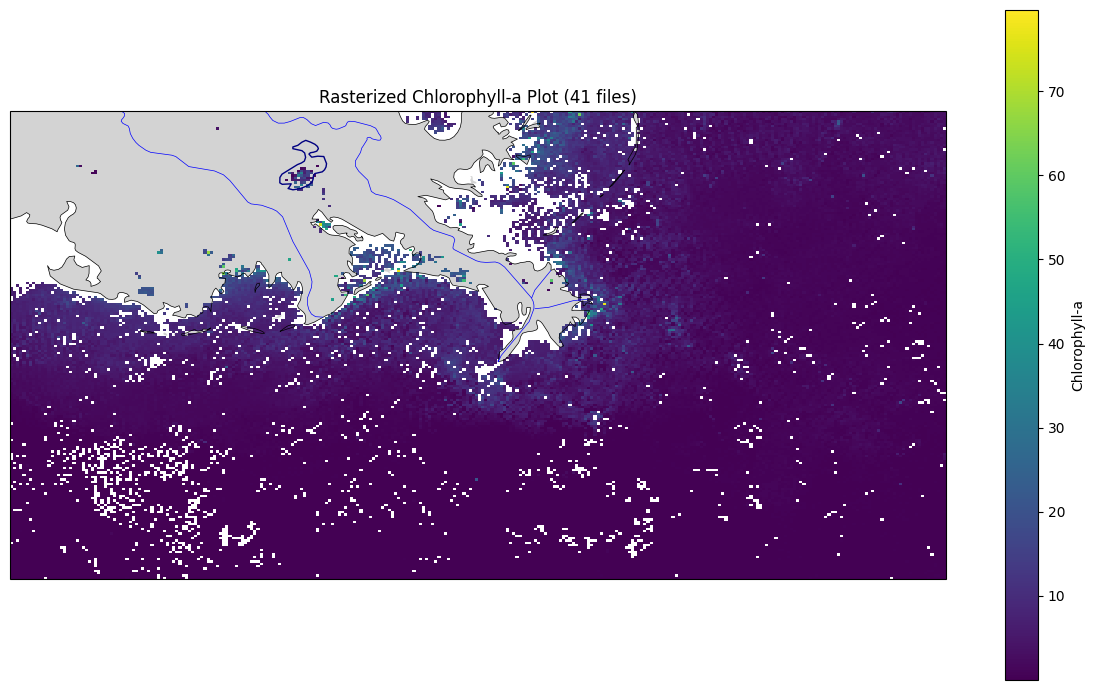

In [ ]:
from scipy.stats import binned_statistic_2d

# === Define Bounding Box for Chlorophyll-a Data ===
lon_min, lon_max = -91.5, -87.5
lat_min, lat_max = 28.0, 30.0

# === Clip data to the bounding box ===
mask = ((all_lon >= lon_min) & (all_lon <= lon_max) & (all_lat >= lat_min) & (all_lat <= lat_max))
clipped_lon = all_lon[mask]
clipped_lat = all_lat[mask]
clipped_var = all_var[mask]

# === Define binning parameters ===
lat_bins, lon_bins = 200, 300

# === Compute 2D binned mean statistic over the clipped data ===
stat, lat_edges, lon_edges, _ = binned_statistic_2d(
    clipped_lat, clipped_lon, clipped_var, statistic='mean', bins=[lat_bins, lon_bins],
    range=[[lat_min, lat_max], [lon_min, lon_max]]
)

# === Generate meshgrid for pcolormesh using bin edges ===
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

In [ ]:
# === Plotting the Rasterized Chlorophyll-a Map ===
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent using the bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the raster data with a consistent color map
raster = ax.pcolormesh(
    lon_grid, lat_grid, stat,
    cmap='viridis', shading='auto',
    transform=ccrs.PlateCarree()
)

# Add coastlines and land features for context
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')  # added river annotations
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')  # added lake annotations

# Display a colorbar and map title
plt.colorbar(raster, label='Chlorophyll-a')
plt.title(f"Rasterized Chlorophyll-a Plot ({len(datasets)} files)")
plt.tight_layout()
plt.show()

### Selective NaN Interpolation

This section uses the `SelectiveInterpolator` class from l2_pipeline to fill small gaps in the data while preserving larger NaN regions. The algorithm:

1. Identifies connected regions of NaN values using image labeling
2. Determines the size of each NaN region (number of connected bins)
3. Only interpolates NaN regions that have fewer than a threshold number of bins
4. Preserves larger NaN regions and "islands" surrounded by NaN values

Found NaN regions and interpolated the small ones (threshold: 32 connected bins)


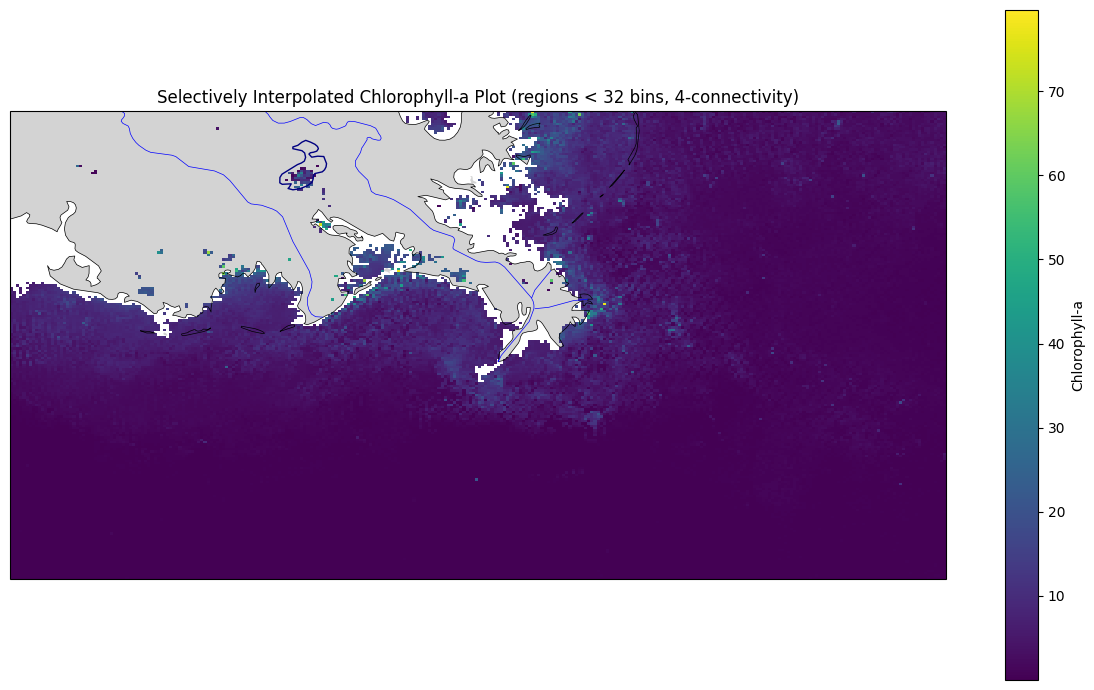

In [ ]:
# Set the threshold for small regions
threshold = 32  # regions with fewer than this number of connected bins will be interpolated

# Use the SelectiveInterpolator class for interpolation
stat_selective_interp = SelectiveInterpolator.interpolate(stat, lat_edges, lon_edges, threshold)

# Create a new figure for selective interpolation
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent using the bounding box
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the selectively interpolated data
raster = ax.pcolormesh(
    lon_grid, lat_grid, stat_selective_interp,
    cmap='viridis', shading='auto',
    transform=ccrs.PlateCarree()
)

# Add coastlines and land features for context
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='navy', linestyle='-')

# Display a colorbar and map title
plt.colorbar(raster, label='Chlorophyll-a')
plt.title(f"Selectively Interpolated Chlorophyll-a Plot (regions < {threshold} bins, 4-connectivity)")
plt.tight_layout()
plt.show()